In [1]:
# Data Analysis Exercise: Meal-Prep-Time

# This notebook serves as an initial analysis and exploration of the data, plus an intial
# fitting and evaluation of a predictive model for food preparation time through use of 
# the XGBRegressor algorithm. 

In [2]:
# importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBRegressor

import warnings
warnings.filterwarnings("ignore")

# importing csv files
orders = pd.read_csv('app/source/orders.csv')
restaurants = pd.read_csv('app/source/restaurants.csv')

In [3]:
# inspecting 'orders' (based on orders.csv)
orders.shape # 32394 rows, 6 columns
orders.columns # column names: order_acknowledged_at, order_ready_at, order_value_gbp, restaurant_id, number_of_items, prep_time_seconds

Index(['order_acknowledged_at', 'order_ready_at', 'order_value_gbp',
       'restaurant_id', 'number_of_items', 'prep_time_seconds'],
      dtype='object')

In [4]:
orders['order_acknowledged_at'].head() # previewing 'order_acknowledged_at' column

0    2015-06-01 12:28:28.952789+01:00
1    2015-06-06 17:06:24.434807+01:00
2    2015-06-08 14:56:15.503204+01:00
3    2015-06-12 15:12:20.497925+01:00
4    2015-06-01 13:07:10.794050+01:00
Name: order_acknowledged_at, dtype: object

In [5]:
orders['order_ready_at'].head() # previewing 'order_ready_at' column

0    2015-06-01 14:12:09.474896+01:00
1    2015-06-06 17:16:27.520253+01:00
2    2015-06-08 15:03:39.397496+01:00
3    2015-06-12 15:23:30.064683+01:00
4    2015-06-01 14:02:25.104517+01:00
Name: order_ready_at, dtype: object

In [6]:
# converting 'order_acknowledged_at', 'order_ready_at' columns to datetime format
orders['order_acknowledged_at'] = pd.to_datetime(orders['order_acknowledged_at'])
orders['order_ready_at'] = pd.to_datetime(orders['order_ready_at'])

In [7]:
# creating a new column 'diff' which represents the difference between 'order_ready_at' and 'order_acknowledged_at'
orders['diff'] = orders['order_ready_at'] - orders['order_acknowledged_at']
orders['diff'] = orders['diff'].apply(lambda x: int(x.total_seconds()))

In [8]:
orders['diff'] == orders['prep_time_seconds'] # verifying equivalence between the columns

0        True
1        True
2        True
3        True
4        True
         ... 
32389    True
32390    True
32391    True
32392    True
32393    True
Length: 32394, dtype: bool

In [9]:
# 'prep_time_seconds' appears to be equivalent to 'diff', our calculated column

In [10]:
del orders['diff'] # removing 'diff' column (no longer needed)

In [11]:
# exploring 'restaurant_id' column
orders['restaurant_id'].value_counts() # it appears that some restaurants have very few orders
                                       # (as low as 1 order per restaurant)

408     679
365     339
1939    312
20      281
1390    250
       ... 
2459      1
2830      1
2968      1
2697      1
2274      1
Name: restaurant_id, Length: 1697, dtype: int64

Text(0, 0.5, 'frequency')

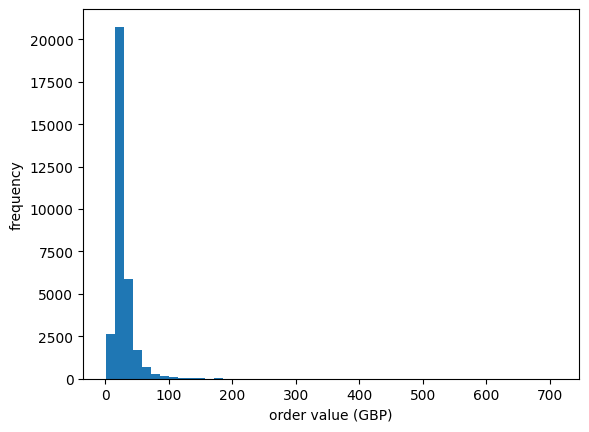

In [12]:
# visualization of 'order_value_gbp' column
plt.hist(orders['order_value_gbp'], bins=50)
plt.xlabel('order value (GBP)') 
plt.ylabel('frequency')

Text(0, 0.5, 'frequency')

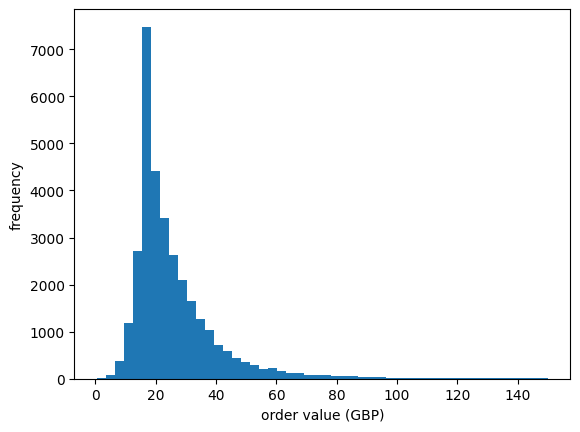

In [13]:
# based on the figure, the majority of orders appear to be under 150 GBP or so.
# let's visualize another histogram using orders less than or equal to 150 GBP.

tempDf = orders[orders['order_value_gbp'] <= 150]
plt.hist(tempDf['order_value_gbp'], bins=50)
plt.xlabel('order value (GBP)') 
plt.ylabel('frequency')

In [14]:
np.round(np.median(orders['order_value_gbp']),2) # the median order value is 21.4 GBP

21.4

In [15]:
# inspecting 'restaurants' (based on restaurants.csv)
restaurants.shape # 1697 rows, 4 columns
restaurants.columns # column names: restaurant_id, country, city, type_of_food

Index(['restaurant_id', 'country', 'city', 'type_of_food'], dtype='object')

Text(0, 0.5, 'frequency')

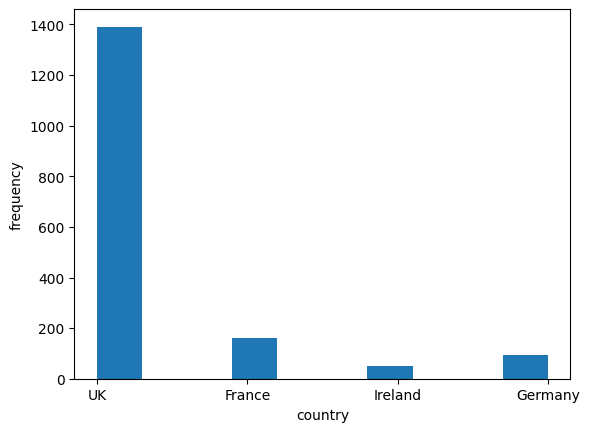

In [16]:
# visualization of 'country' column
plt.hist(restaurants['country'])
plt.xlabel('country')
plt.ylabel('frequency') # most entries appear to be from the UK, followed by France, Germany, and Ireland

In [17]:
# exploring 'city' column
restaurants['city'].value_counts() # some cities have relatively low counts

London         998
Paris          161
Berlin          77
Manchester      72
Dublin          52
Birmingham      49
Brighton        40
Edinburgh       37
Glasgow         33
Oxford          23
Leeds           23
Nottingham      22
Liverpool       20
Cambridge       17
München         16
Bristol         15
Reading         11
Guildford        9
Cheltenham       8
Leicester        8
Cardiff          4
Southampton      2
Name: city, dtype: int64

In [18]:
# exploring 'type_of_food' column
restaurants['type_of_food'].value_counts() # some food types have relatively low counts

italian         294
indian          134
burgers         119
american        104
thai             85
               ... 
portuguese        1
soup              1
austrian          1
delicatessen      1
ice cream         1
Name: type_of_food, Length: 83, dtype: int64

In [19]:
# merging 'orders' and 'restaurants' variables to single DataFrame
df = orders.merge(restaurants,on='restaurant_id') # merging by 'restaurant_id' column

In [20]:
# let's calculate the median order time for each country

countries = ['UK','France','Ireland','Germany']
countryDf = pd.DataFrame(columns=['country','median_prep_s'])

for country in countries:
    tempDf = df[df['country'] == country]
    countryDf = countryDf.append({'country':country,'median_prep_s':np.median(tempDf['prep_time_seconds'])},ignore_index=True)
    
countryDf.sort_values(by='median_prep_s').reset_index(drop=True)

,country,median_prep_s
0,France,259.5
1,Germany,800.5
2,UK,845.0
3,Ireland,888.0


In [21]:
# interestingly, the median preparation time is significantly lower for France than for all other countries.

In [22]:
# let's take a look at the top 5 restaurants by number of orders

mostOrders = pd.DataFrame(df['restaurant_id'].value_counts().reset_index()).rename(columns={'index':'restaurant_id','restaurant_id':'count'}).head()
mostOrders # the top 5 restaurants have between 250 and 679 orders in total

,restaurant_id,count
0,408,679
1,365,339
2,1939,312
3,20,281
4,1390,250


In [23]:
# let's calculate the standard deviation of preparation time for the top 5 restaurants by number of orders

mostOrders = list(mostOrders['restaurant_id'])
mostOrdersDf = pd.DataFrame(columns=['restaurant_id','median_prep_s','stdev_prep_s'])

for restaurant in mostOrders:
    tempDf = df[df['restaurant_id'] == restaurant]
    mostOrdersDf = mostOrdersDf.append({'restaurant_id':int(restaurant),'median_prep_s':int(np.median(tempDf['prep_time_seconds'])),'stdev_prep_s':int(np.std(tempDf['prep_time_seconds']))},ignore_index=True)
    
mostOrdersDf['median_prep_m'] = mostOrdersDf['median_prep_s'].apply(lambda x: np.round(x/60,1))
mostOrdersDf['stdev_prep_m'] = mostOrdersDf['stdev_prep_s'].apply(lambda x: np.round(x/60,1))
mostOrdersDf # visualizing the median and standard deviation of the top 5 restaurants in seconds (and minutes)

,restaurant_id,median_prep_s,stdev_prep_s,median_prep_m,stdev_prep_m
0,408,945,1358,15.8,22.6
1,365,594,605,9.9,10.1
2,1939,835,1568,13.9,26.1
3,20,1067,1857,17.8,31.0
4,1390,513,1082,8.6,18.0


In [24]:
# it seems that the standard deviation of the preparation time can vary significantly on the restaurant level,
# with the top 5 restaurants by order numbers showing prep time deviations anywhere between 10.1 minutes and 
# 31 minutes. This suggests features beyond restaurant characteristics can impact order preparation time.

In [25]:
# extracting the hour and minute the order was acknowledged
df['hour_acknowledged'] = df['order_acknowledged_at'].apply(lambda x: x.hour) # hour acknowledged
df['minute_acknowledged'] = df['order_acknowledged_at'].apply(lambda x: x.hour*60 + x.minute) # minute acknowledged

In [26]:
# let's visualize median prep times for all restaurants based on the hour of day that the order was acknowledged
hourVis = pd.DataFrame(columns=['hour_acknowledged','med_prep_time'])

for i in range(0,24):
    hDf = df[df['hour_acknowledged'] == i]
    mpt = np.median(hDf['prep_time_seconds'])
    
    if len(hDf) >= 10: # using minimum of 10 samples per hour to calculate median
        hourVis = hourVis.append({'hour_acknowledged':i,'med_prep_time':mpt},ignore_index=True)

Text(0, 0.5, 'median prep time (s)')

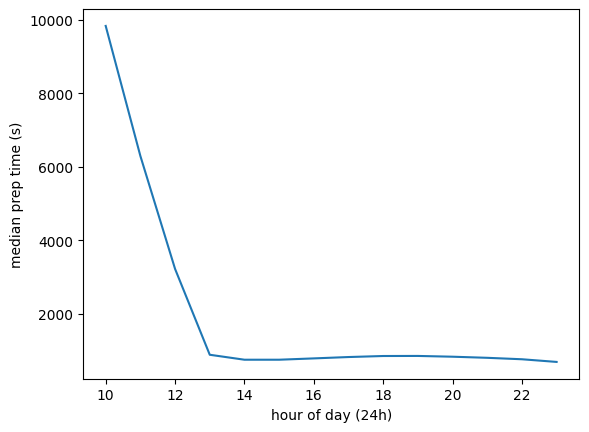

In [27]:
plt.plot(hourVis['hour_acknowledged'][1:],hourVis['med_prep_time'][1:]) # hourly visualization from 10AM onwards
plt.xlabel('hour of day (24h)')
plt.ylabel('median prep time (s)')

In [28]:
# it appears that in general, the median preparation time for restaurants is significantly 
# higher before noon after which a sharp decline is experienced in the following hours.
#
# this indicates that the time of day that the order was acknowledged can potentially
# impact food preparation time. We can use the hour or minute acknowledged as a model input.

In [29]:
del df['order_ready_at'], df['order_acknowledged_at'], df['hour_acknowledged'] # minute_acknowledged used

Text(0, 0.5, 'frequency')

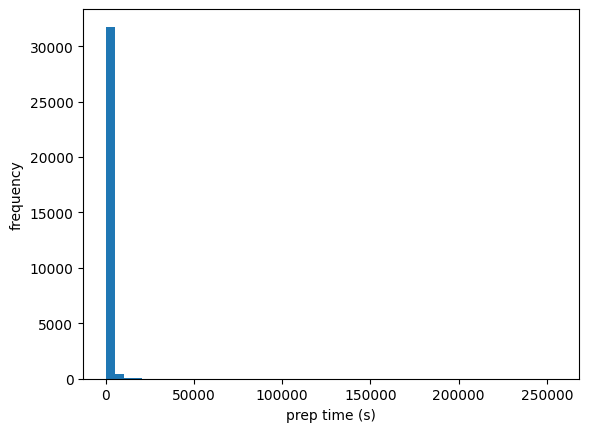

In [30]:
# visualization of 'prep_time_seconds' column
plt.hist(df['prep_time_seconds'], bins=50)
plt.xlabel('prep time (s)') 
plt.ylabel('frequency')

In [31]:
# there appear to be significant outliers in the prep time data - let's remove these.
q_upper = df['prep_time_seconds'].quantile(0.99) # upper outlier bound = 7634.2s
df = df[(df['prep_time_seconds'] < q_upper)]

Text(0, 0.5, 'frequency')

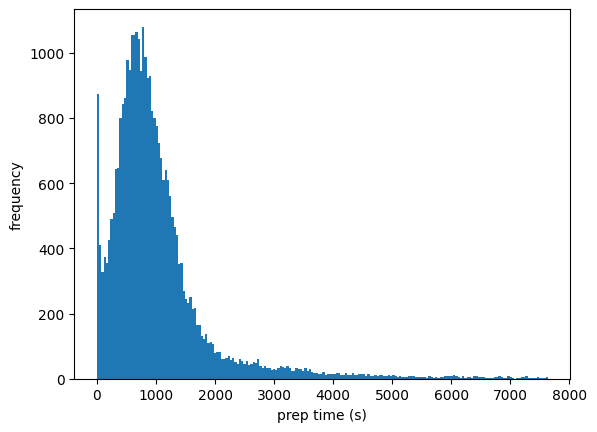

In [32]:
# re-plotting
plt.hist(df['prep_time_seconds'], bins=200)
plt.xlabel('prep time (s)')
plt.ylabel('frequency')

In [33]:
# encoding of 'country', 'city', and 'type_of_food' columns as integers
encode = LabelEncoder()
variables = ['country', 'city', 'type_of_food']

for var in variables:
    df[var] = encode.fit_transform(df[var]) 

In [34]:
# assigning labels variable 
labels = df['prep_time_seconds'] # label = 'prep_time_seconds'
del df['prep_time_seconds'], df['restaurant_id'] # removing 'prep_time_seconds', 'restaurant_id' from features

# assigning features variable
features = df

In [35]:
features.head() # input features used for model

,order_value_gbp,number_of_items,country,city,type_of_food,minute_acknowledged
0,59.90,2,3,14,13,748
1,24.00,8,3,14,13,1026
2,15.25,3,3,14,13,896
3,28.05,8,3,14,13,912
4,56.30,7,3,14,16,787


In [36]:
# Assigning training, testing splits and fitting model to XGBRegressor
X_train, X_test, y_train, y_test = train_test_split(features,labels,test_size=0.3,random_state=0) # 70%/30% split

reg = XGBRegressor()
reg.fit(X_train,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.300000012, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=6, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, ...)

Text(0, 0.5, 'predicted preparation time (s)')

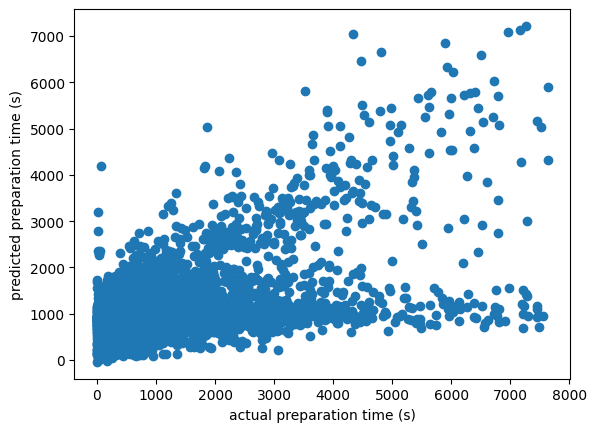

In [37]:
# evaluating predictive performance with test data
prediction = reg.predict(X_test)

plt.scatter(y_test,prediction)
plt.xlabel('actual preparation time (s)')
plt.ylabel('predicted preparation time (s)')

In [38]:
print('R2 score:',np.round(r2_score(y_test,prediction),2))

R2 score: 0.31


In [39]:
print('Mean Absolute Error:',np.round(mean_absolute_error(y_test, prediction),1),'seconds')

Mean Absolute Error: 480.1 seconds


In [40]:
# Let's calculate the feature importances as determined by XGBRegressor
importances = pd.DataFrame(reg.feature_importances_,index=features.columns).sort_values(by=0, ascending=False)
importances = importances.rename(columns={0:'importance'})

In [41]:
importances

,importance
minute_acknowledged,0.376094
country,0.294947
city,0.091126
order_value_gbp,0.090822
type_of_food,0.081299
number_of_items,0.065712


In [42]:
# from the provided XGBRegressor importances, we can see that 'minute_acknowledged' and 'country'
# are attributed the highest importancs followed by 'city', 'order_value_gbp', 'type_of_food', 
# and 'number_of_items'.

In [43]:
# Some notes: 'minute_acknowledged' is attributed a relatively high feature importance in this run of the model.
# It was previously illustrated that median preparation time is significantly higher early in the day compared
# to afternoon hours, therefore time of day acknowledged is likely a significant factor in preparation time.

# We also saw that significant deviations exist in prep time on an individual restaurant level. This indicates
# that factors beyond country, city, and type_of_food classification can influence the order preparation time
# since these remain constant per restaurant.

# Since 'city', 'order_value_gbp', 'type_of_food' and 'number_of_items' are determined to be of relatively low
# importance by the model, there are likely other variables not included that can significantly impact food
# preparation time.

# Examples of such variables could be the specific food items ordered or the number of staff available when
# the order is placed.

# For example, a customer may order 20 cans of a soft drink - even though the order consists of 20 items, the
# order preparation time is likely less than that of a dish that requires cooking. Therefore, the number of
# items in the order can only tell so much about the preparation time required for an order. Similarly, if
# a restaurant receives 50 orders of several items in an hour and there is only one staff member available
# to prepare orders, the restaurant may not have the bandwidth to prepare these items as quickly as usual.